Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Generate Synthetic Data with CTAB-GAN+

* <b>NOTES</b>
  * Can't be installed through `pip`, but you can git clone the library [here][1].
    * `git clone https://github.com/Team-TUD/CTAB-GAN-Plus.git` 
  * Data input has to be a csv file...
  * Check [here][2] to tune synthesizer's params. It doesn't allow you to tune GAN related parameters such as epoch, learning rate, etc.
  * it has built-in progress bar to show model fitting progress
  
[1]:https://github.com/team-tud/ctab-gan-plus
[2]:https://github.com/Team-TUD/CTAB-GAN-Plus/blob/main/model/ctabgan.py#L17-L25

In [1]:
import pandas as pd
import numpy as np
import sys

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import LGBMClassifier

from utils import *

sys.path.insert(0, 'CTAB-GAN-Plus')
from model.ctabgan import CTABGAN

import warnings
warnings.filterwarnings('ignore')

## Generate Data Input

In [2]:
raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
print(raw_df.shape)

raw_df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [3]:
target = 'deposit'
num_cols = [col for col in raw_df.columns if raw_df[col].dtype != 'O' and col != target]
cat_cols = [col for col in raw_df.columns if raw_df[col].dtype == 'O' and col != target]

print(len(num_cols), len(cat_cols))
print(num_cols)
print(cat_cols)

7 9
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(len(X_train)/len(raw_df))
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test.head()

(8371, 16) (2791, 16) (8371,) (2791,)
0.7499552051603655
0    0.526102
1    0.473898
Name: deposit, dtype: float64
0    0.526335
1    0.473665
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,33,admin.,married,secondary,no,7,yes,no,cellular,17,apr,612,1,148,1,failure
1,59,retired,married,tertiary,no,422,yes,no,cellular,14,may,647,4,-1,0,unknown
2,25,student,single,unknown,no,3,no,no,cellular,26,may,170,1,-1,0,unknown
3,51,blue-collar,married,primary,no,4497,yes,no,unknown,15,may,276,3,-1,0,unknown
4,49,admin.,single,secondary,no,293,no,no,cellular,28,jun,452,1,-1,0,unknown


In [5]:
# generate the data input required by CTAB-GAN+
train_df = pd.concat([X_train, y_train], axis=1)
print(train_df.shape)
train_df.to_csv('campaign_train.csv', index=False)

(8371, 17)


## Generate Synthetic Data with CTAB-GAN+

In [9]:
# using num_cols as `general_columns`
synthesizer1 =  CTABGAN(raw_csv_path = 'campaign_train.csv',
                 test_ratio = 0.20,
                 categorical_columns = cat_cols,   
                 log_columns = [],
                 mixed_columns= {},
                 general_columns= num_cols,
                 non_categorical_columns= [],
                 integer_columns = [],
                 problem_type= {'Classification': target}) 
synthesizer1.fit()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [20:19<00:00,  8.13s/it]

Finished training in 1224.5222499370575  seconds.


In [14]:
syn1 = synthesizer1.generate_samples()
print(syn1.shape)
syn1.to_csv('syn_ctabgan+_gencols.csv', index= False)

(8371, 17)


In [5]:
# using num_cols as `non_categorical_columns`
synthesizer2 =  CTABGAN(raw_csv_path = 'campaign_train.csv',
                 test_ratio = 0.20,
                 categorical_columns = cat_cols,   
                 log_columns = [],
                 mixed_columns= {},
                 general_columns= [],
                 non_categorical_columns= num_cols,
                 integer_columns = [],
                 problem_type= {'Classification': target}) 
synthesizer2.fit()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [28:34<00:00, 11.43s/it]

Finished training in 1727.6528532505035  seconds.


In [6]:
syn2 = synthesizer2.generate_samples()
print(syn2.shape)
syn2.to_csv('syn_ctabgan+_noncatcols.csv', index= False)

(8371, 17)


## Evaluate Generated Synthetic Data

* Compare distributions of real data and synthetic data
* Compare model efficacy using real data and synthetic data

In [6]:
syn_X_train_gencols = pd.read_csv('syn_ctabgan+_gencols.csv')
print(min(syn_X_train_gencols['pdays']))

display(syn_X_train_gencols.head())

syn_X_train_gencols.drop(target, axis=1, inplace=True)

-0.999975323677063


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,29.109070,technician,single,secondary,no,-1612.294528,yes,yes,unknown,24.058130,may,198.897461,1.265452,3.883338,0.199183,unknown,0.001669
1,44.578110,blue-collar,married,primary,no,-1814.798200,yes,no,cellular,9.392412,may,191.999542,2.503400,-0.947228,0.031382,unknown,0.000879
2,53.537712,blue-collar,divorced,primary,no,756.911830,no,no,cellular,21.331472,jul,399.585205,1.565781,-0.943744,0.065392,unknown,0.000964
3,30.391609,blue-collar,married,secondary,no,30.840257,no,no,cellular,15.484458,aug,616.763062,1.258049,88.139160,3.210371,failure,0.002381
4,39.708023,management,divorced,tertiary,no,-739.193271,yes,no,cellular,25.088676,jul,127.154114,1.736958,-0.727936,0.282944,unknown,0.000824


In [7]:
syn_X_train_noncatcols = pd.read_csv('syn_ctabgan+_noncatcols.csv')
print(min(syn_X_train_noncatcols['pdays']))

display(syn_X_train_noncatcols.head())

syn_X_train_noncatcols.drop(target, axis=1, inplace=True)

-0.9999911064239988


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,55.592415,admin.,divorced,secondary,no,6656.454035,no,no,cellular,1.081328,aug,84.407113,1.009803,92.790223,0.979397,failure,0.998294
1,30.298174,management,single,tertiary,no,149.341958,no,no,cellular,5.707229,jul,384.083812,2.003830,265.019219,7.554963,failure,0.999742
2,68.551232,retired,divorced,primary,no,1064.792886,no,no,cellular,16.948604,nov,684.145960,4.002624,-0.952339,0.004613,unknown,0.999688
3,34.751290,admin.,divorced,tertiary,no,739.020939,yes,no,cellular,16.758183,may,42.099082,2.005787,322.750036,7.586393,failure,0.998248
4,36.238824,management,married,tertiary,no,2319.448603,no,no,cellular,24.920763,apr,713.153475,1.992376,48.149892,8.968798,failure,0.999906


In [8]:
real_num_df = X_train[num_cols]
real_num_df['data_mark'] = 'real'
real_cat_df = X_train[cat_cols]
real_cat_df['data_mark'] = 'real'

syn_num_df_gencols = syn_X_train_gencols[num_cols]
syn_num_df_gencols['data_mark'] = 'synthetic_gencols'
syn_cat_df_gencols = syn_X_train_gencols[cat_cols]
syn_cat_df_gencols['data_mark'] = 'synthetic_gencols'

syn_num_df_noncatcols = syn_X_train_noncatcols[num_cols]
syn_num_df_noncatcols['data_mark'] = 'synthetic_noncatcols'
syn_cat_df_noncatcols = syn_X_train_noncatcols[cat_cols]
syn_cat_df_noncatcols['data_mark'] = 'synthetic_noncatcols'

In [9]:
compare_num_df1 = pd.concat([real_num_df, syn_num_df_gencols], ignore_index=True)
compare_cat_df1 = pd.concat([real_cat_df, syn_cat_df_gencols], ignore_index=True)
compare_num_df1['balance'] = compare_num_df1['balance'].astype('float')
compare_num_df1['logged_balance'] = np.log(abs(compare_num_df1['balance']) + 1) * np.sign(compare_num_df1['balance'])

compare_num_df2 = pd.concat([real_num_df, syn_num_df_noncatcols], ignore_index=True)
compare_cat_df2 = pd.concat([real_cat_df, syn_cat_df_noncatcols], ignore_index=True)
compare_num_df2['balance'] = compare_num_df2['balance'].astype('float')
compare_num_df2['logged_balance'] = np.log(abs(compare_num_df2['balance']) + 1) * np.sign(compare_num_df2['balance'])

print(compare_num_df1.shape, compare_cat_df1.shape)
print(compare_num_df2.shape, compare_cat_df2.shape)

(16742, 9) (16742, 10)
(16742, 9) (16742, 10)


### Compare Distributions

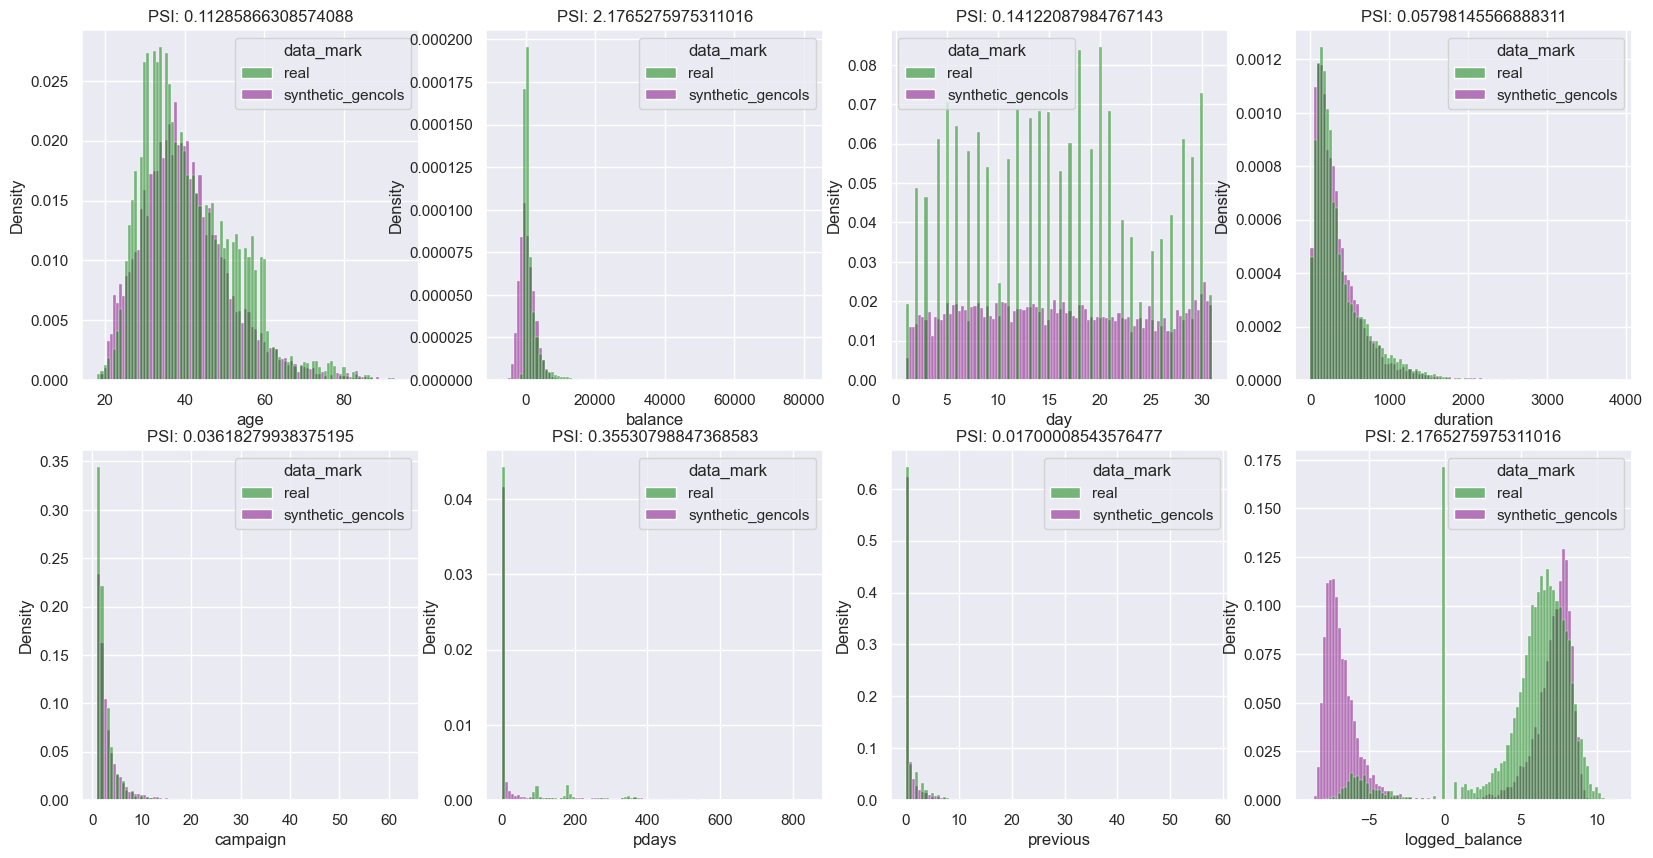

In [11]:
plot_num_feature_distribution_per_group(compare_num_df1, group_col='data_mark', n_rows=2, n_cols=4, exclude_cols=['data_mark'], 
                                            figsize=[20, 10], font_scale=1, group_values=['real', 'synthetic_gencols'],
                                            bins=100, palette=['green', 'purple'], distribution_metrics='psi', enable_dist_comp=True)

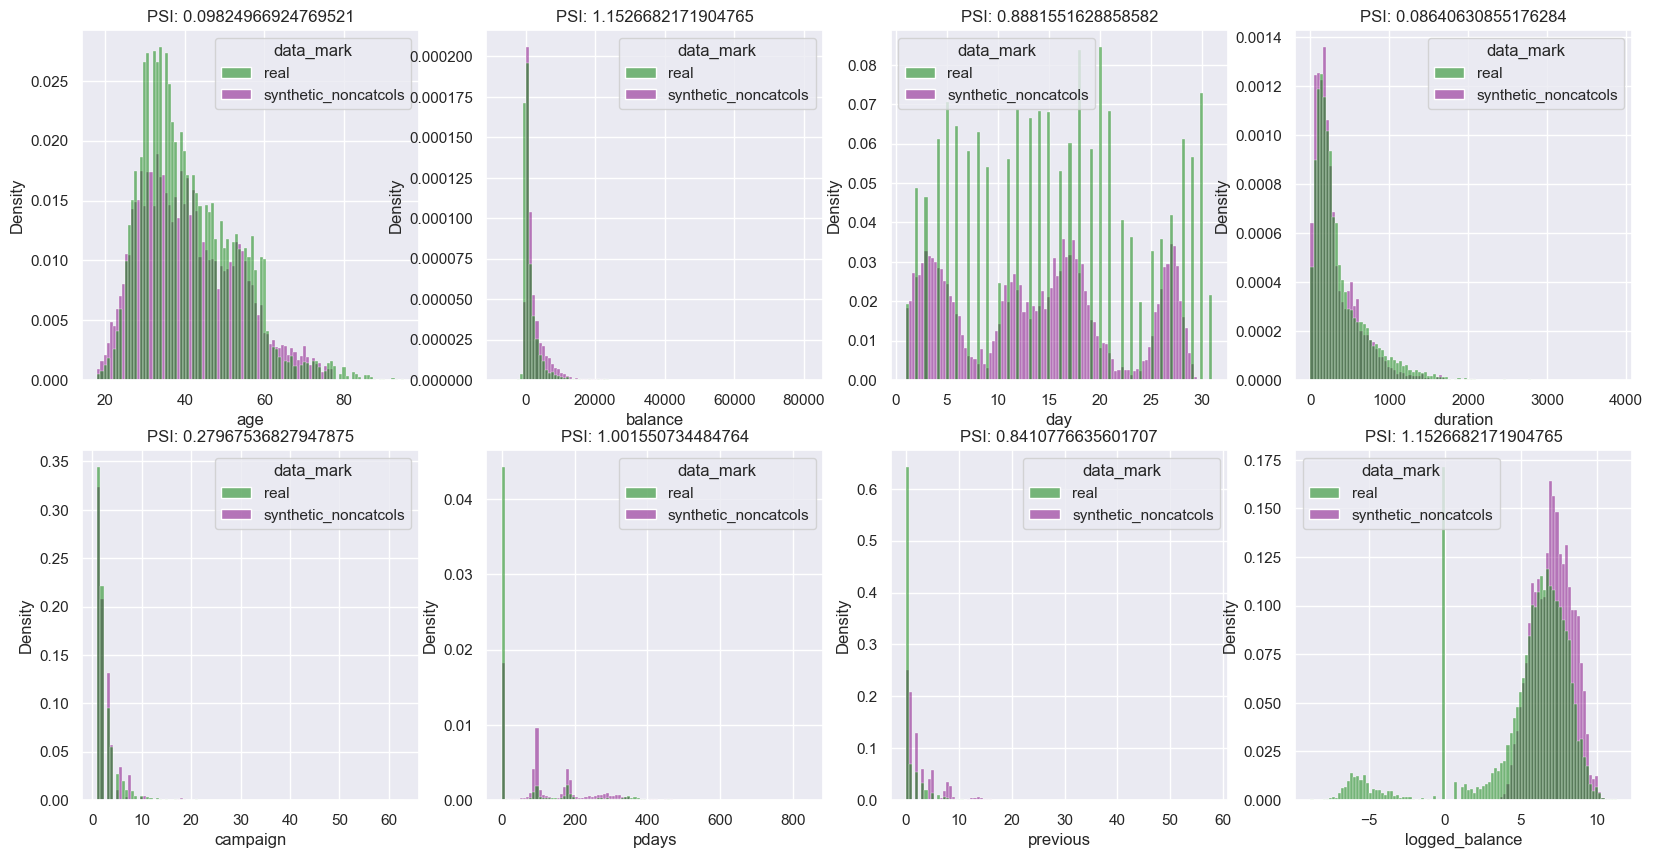

In [13]:
plot_num_feature_distribution_per_group(compare_num_df2, group_col='data_mark', n_rows=2, n_cols=4, exclude_cols=['data_mark'], 
                                            figsize=[20, 10], font_scale=1, group_values=['real', 'synthetic_noncatcols'],
                                            bins=100, palette=['green', 'purple'], distribution_metrics='psi', enable_dist_comp=True)

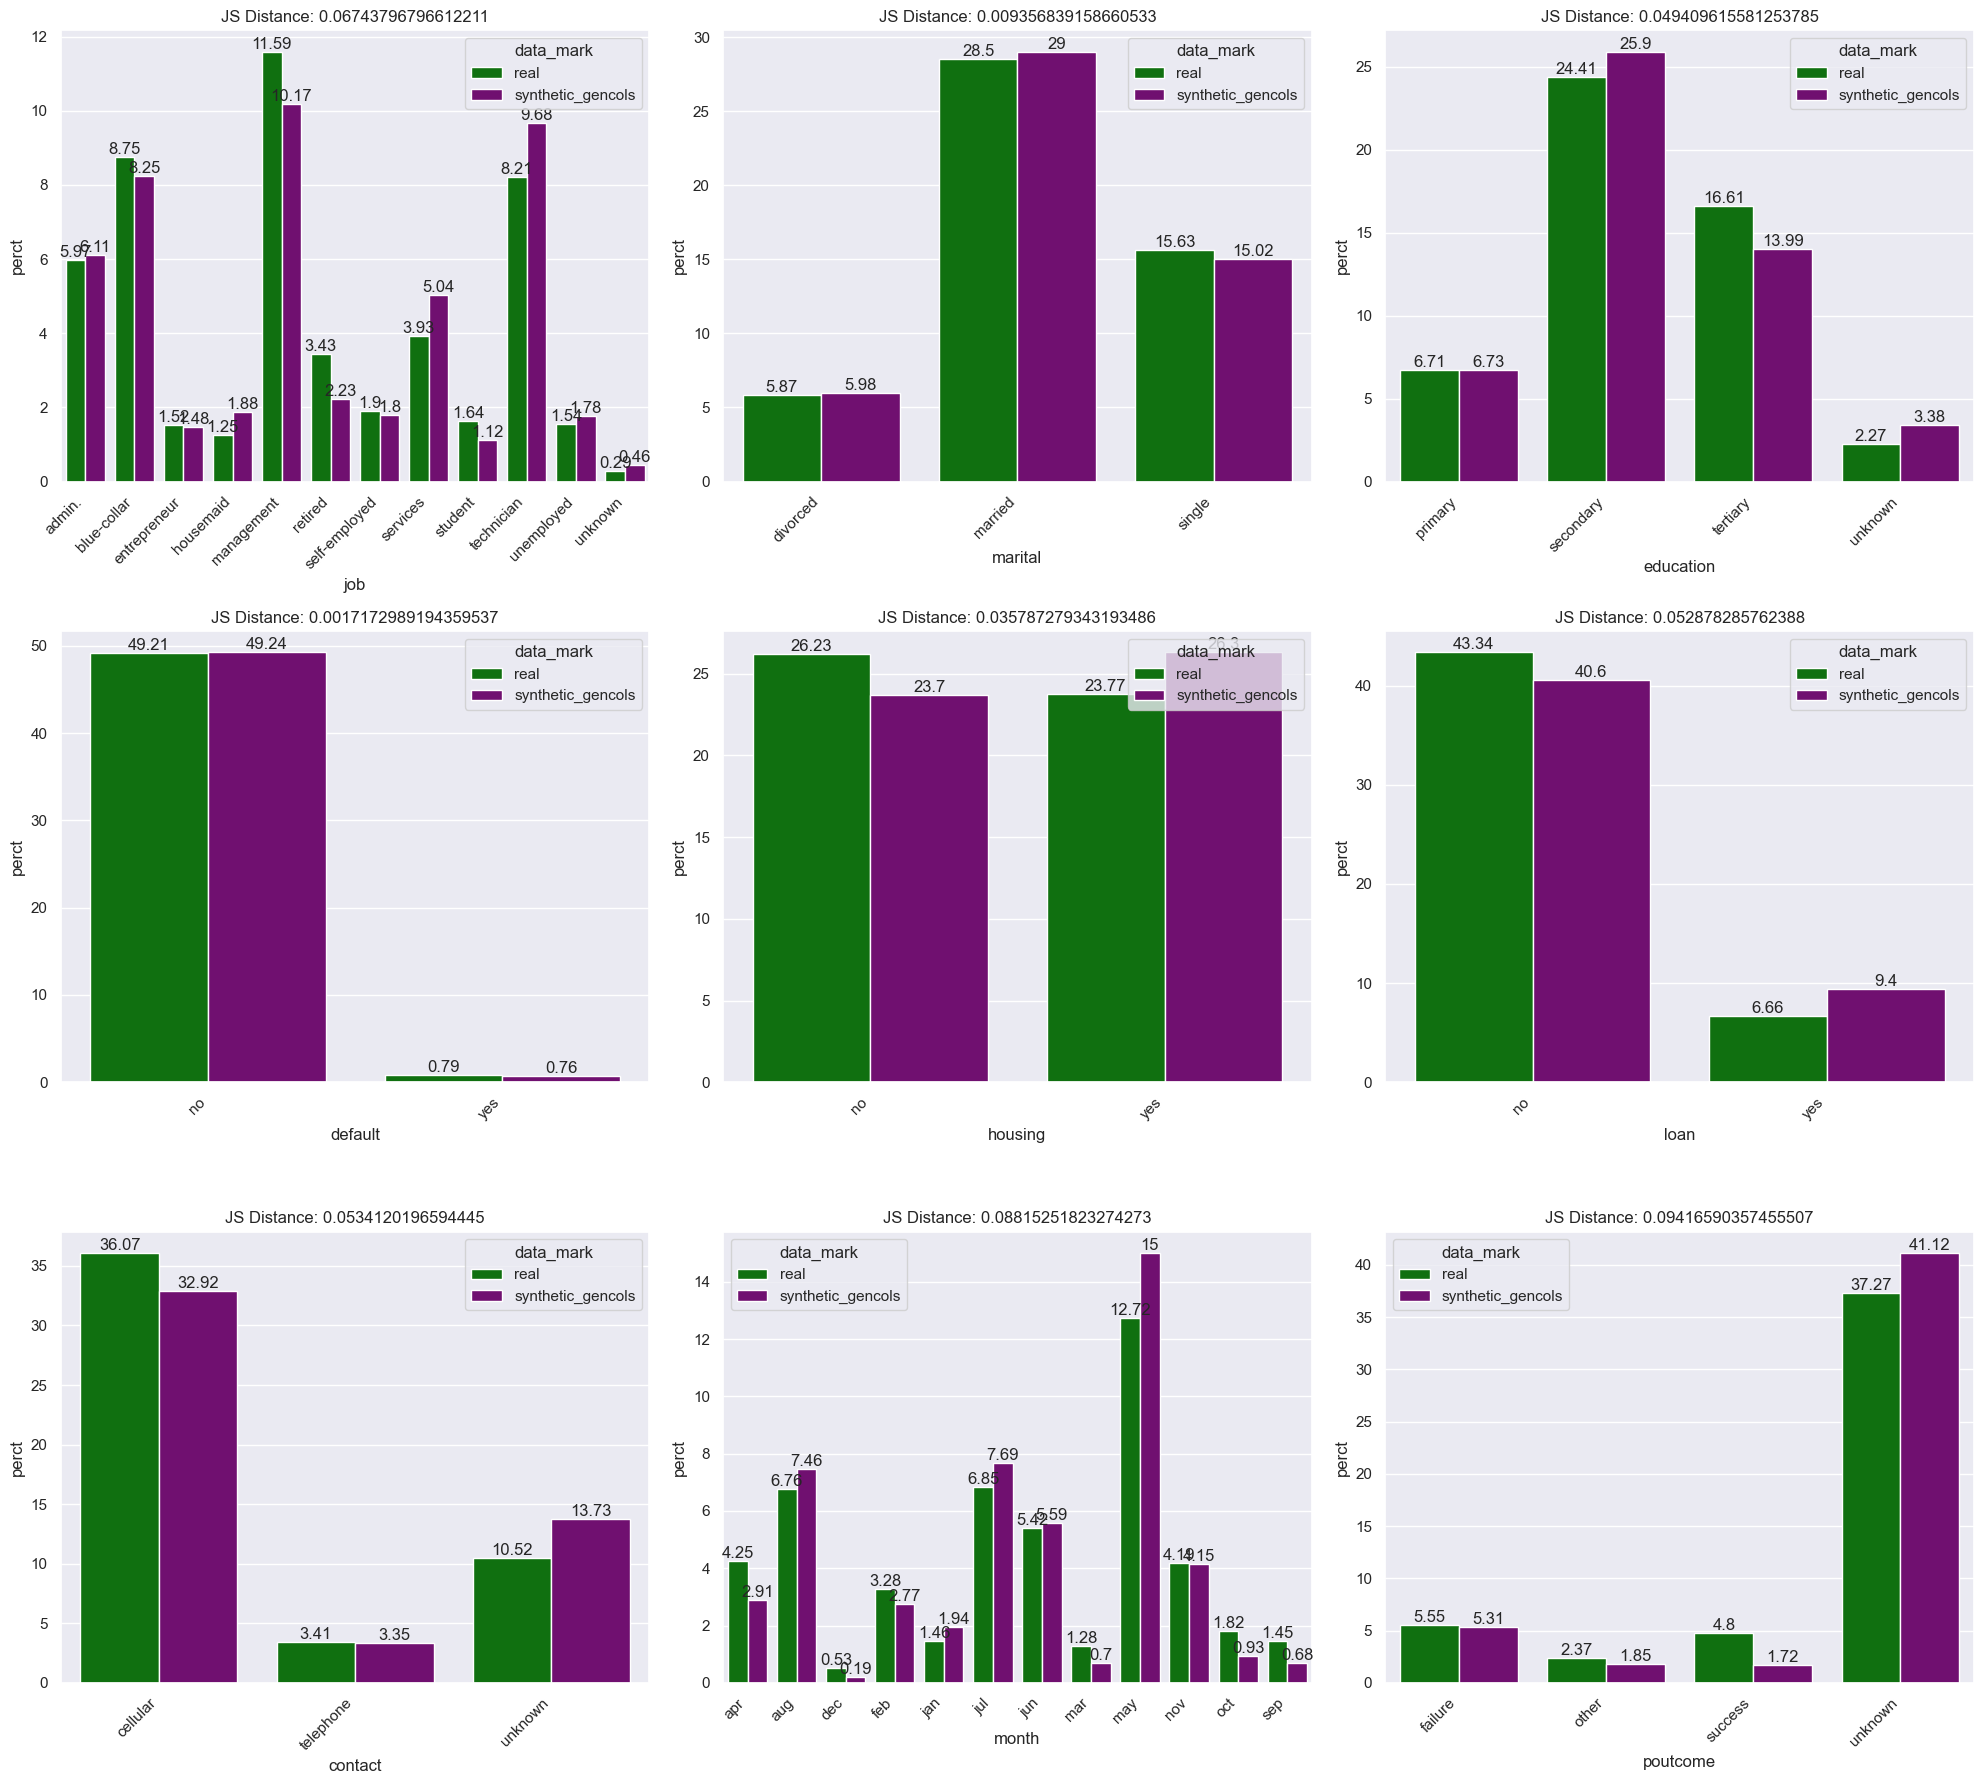

In [12]:
plot_cat_feature_distribution_per_group(compare_cat_df1, group_col='data_mark', 
                                        n_rows=3, n_cols=3, exclude_cols=['data_mark'], 
                                        figsize=[20, 18], font_size=12, palette=['green', 'purple'],
                                        group_values=['real', 'synthetic_gencols'], enable_dist_comp=True)

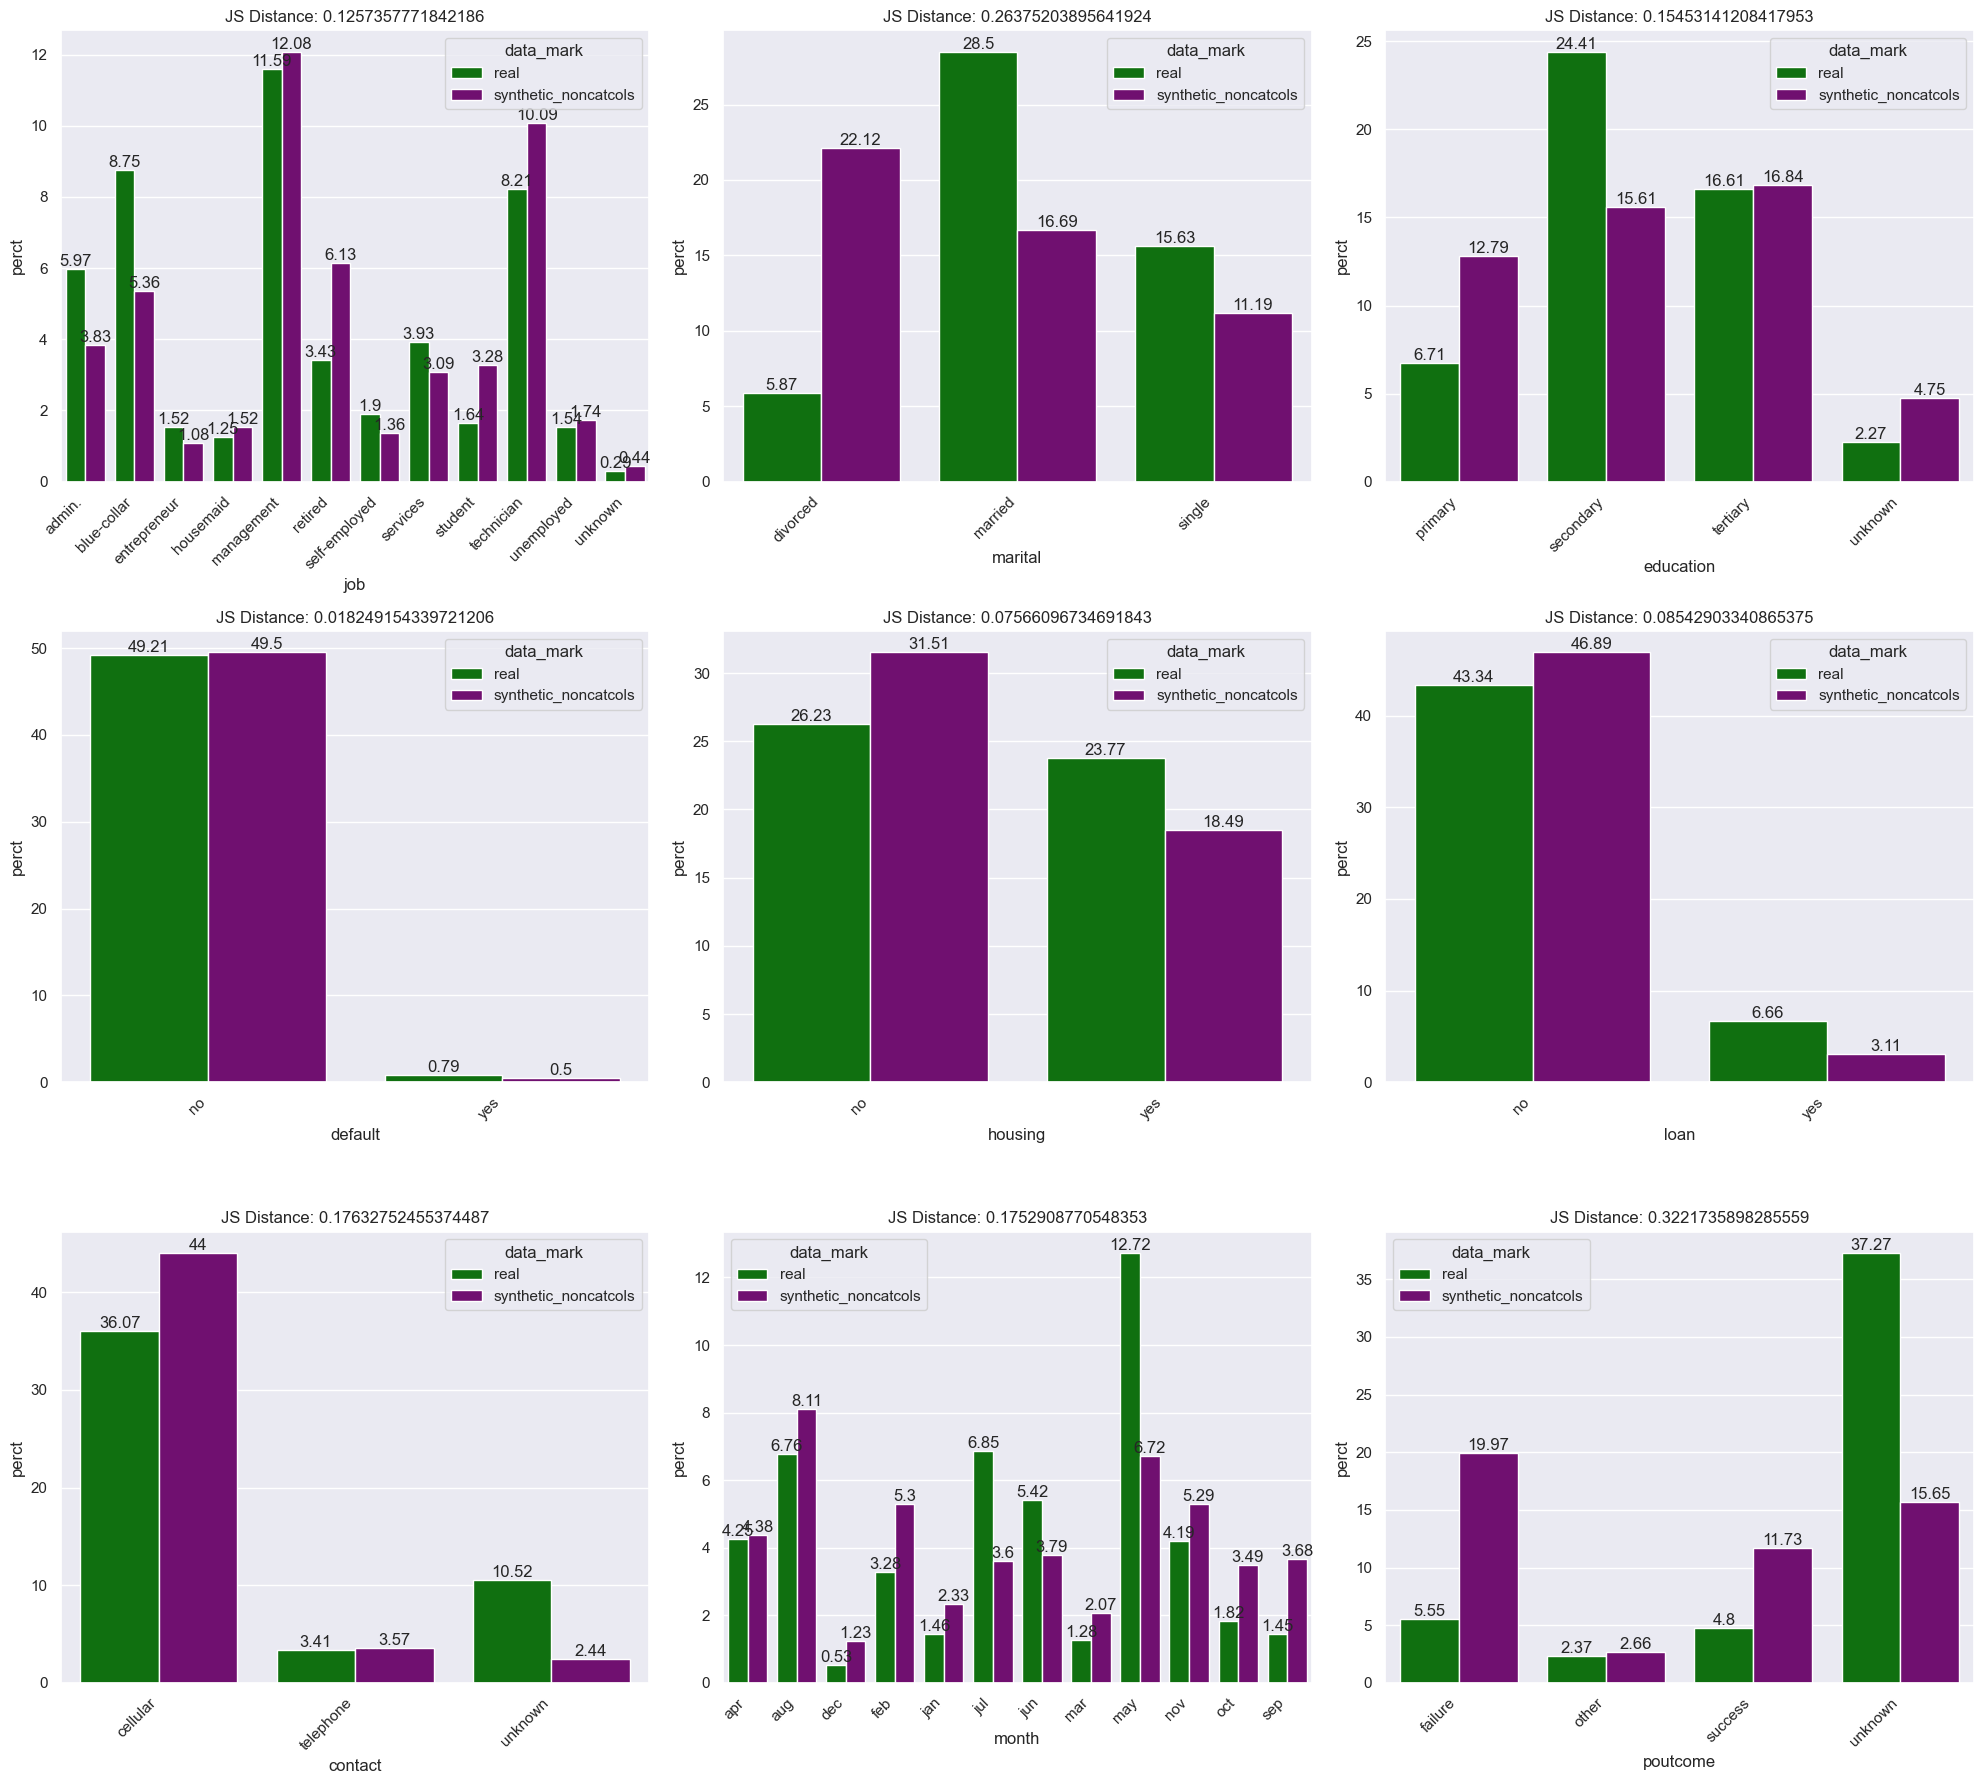

In [14]:
plot_cat_feature_distribution_per_group(compare_cat_df2, group_col='data_mark', 
                                        n_rows=3, n_cols=3, exclude_cols=['data_mark'], 
                                        figsize=[20, 18], font_size=12, palette=['green', 'purple'],
                                        group_values=['real', 'synthetic_noncatcols'], enable_dist_comp=True)

### Compare Model Efficacy

In [10]:
model_params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862, 'bagging_fraction': 0.8506740422636537,
                'feature_fraction': 0.6643670461510903, 'bagging_freq': 18, 'min_data_in_leaf': 1133,
                'num_iterations': 2956, 'objective': 'binary', 'metric': 'auc', 'random_state': 10,
                'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4}

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

syn_X_train_gencols[cat_cols] = syn_X_train_gencols[cat_cols].astype('category')
syn_X_train_noncatcols[cat_cols] = syn_X_train_noncatcols[cat_cols].astype('category')

In [11]:
model_real = LGBMClassifier(**model_params)
model_real.fit(X_train, y_train)
y_pred1 = model_real.predict(X_test)
auc = roc_auc_score(y_test, y_pred1)
avp = average_precision_score(y_test, y_pred1)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.8428958948887189, Testing Average Precision is 0.7699960261639714


In [12]:
model_syn_gencols = LGBMClassifier(**model_params)
model_syn_gencols.fit(syn_X_train_gencols, y_train)
y_pred2 = model_syn_gencols.predict(X_test)
auc = roc_auc_score(y_test, y_pred2)
avp = average_precision_score(y_test, y_pred2)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.4702523354572409, Testing Average Precision is 0.45987991115496685


In [13]:
model_syn_noncatcols = LGBMClassifier(**model_params)
model_syn_noncatcols.fit(syn_X_train_noncatcols, y_train)
y_pred3 = model_syn_noncatcols.predict(X_test)
auc = roc_auc_score(y_test, y_pred3)
avp = average_precision_score(y_test, y_pred3)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.4935095864198993, Testing Average Precision is 0.4704862351418104


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

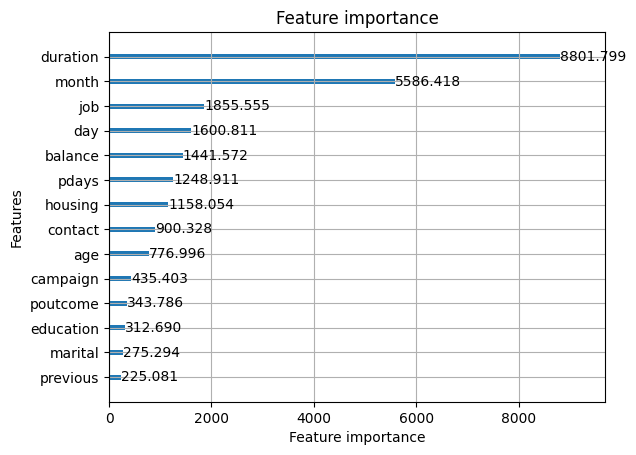

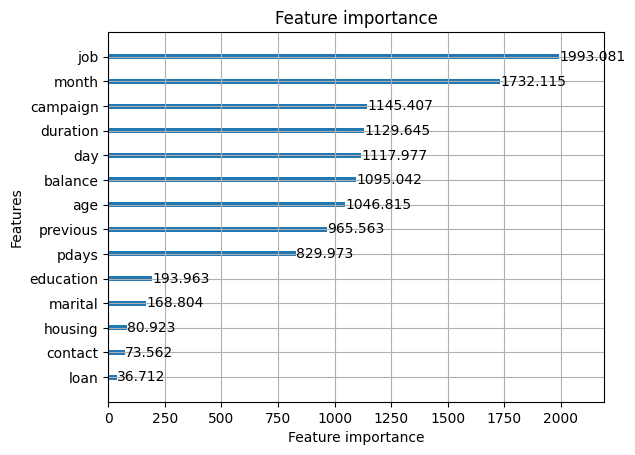

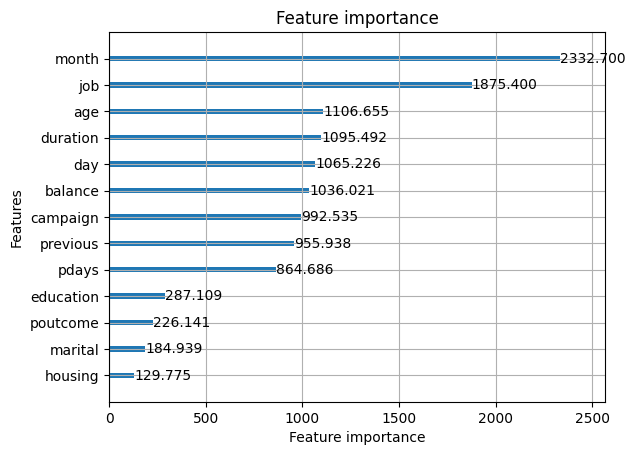

In [14]:
display(lgb.plot_importance(model_real, importance_type='gain'))

display(lgb.plot_importance(model_syn_gencols, importance_type='gain'))

display(lgb.plot_importance(model_syn_noncatcols, importance_type='gain'))